In [13]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'


In [14]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [15]:
# Extract hidden states for both input and reference texts
def extract_char(inputs, references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    extract_chars = []

    # Iterate through the batches of inputs and references
    for i in tqdm(range(0, len(inputs), batch_size), desc="Processing data batches"):
        # Prepare batch for input texts
        batch_inputs = inputs[i:i + batch_size]
        batch_references = references[i:i + batch_size]
        
        # Tokenize both input and reference texts
        inputs_combined = [f"{input_text} [SEP] {reference_text}" for input_text, reference_text in zip(batch_inputs, batch_references)]
        encoded_inputs = tokenizer(inputs_combined, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            # Get hidden states from the model
            outputs = model(**encoded_inputs)
        
        # Average the hidden states from the last layer for the combined input-reference representation
        combined_hidden_states = outputs.last_hidden_state.mean(dim=1)  # shape: (batch_size, hidden_size)
        extract_chars.append(combined_hidden_states.cpu().numpy())
    
    return np.vstack(extract_chars)

In [16]:
# Function to extract hidden states from the outputs of extract_char
def extract_hidden_states(extract_chars, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    
    hidden_states = []
    
    # Process the extract_chars as if they were new texts
    for i in tqdm(range(0, len(extract_chars), batch_size), desc="Processing hidden states"):
        batch_extract_chars = extract_chars[i:i + batch_size]

        # Since batch_extract_chars are already features, we can process them directly.
        # Here, we will simply append them as hidden states since they are already in the form needed.
        hidden_states.append(batch_extract_chars)

    return np.vstack(hidden_states)

In [17]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [18]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


In [20]:
# print("Extracting hidden states for non_infringement texts...")
# X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for non_infringement texts...")
# reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
# print("X_non_infringement:",X_non_infringement.shape)
# print("reference_embeddings_non_infringement:",reference_embeddings_non_infringement.shape)
# X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

# print("Extracting hidden states for infringement texts...")
# X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
# print("Extracting reference embeddings for infringement texts...")
# reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
# X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

print("Extracting characteristics for non_infringement texts/references")
X_non_infringement_char = extract_char(non_infringement_outputs, non_infringement_references, bert_model, bert_tokenizer)
print("Extracting hidden states for X_non_infringement_char")
X_non_infringement_combined = extract_hidden_states(X_non_infringement_char, model, tokenizer)

print("Extracting characteristics for infringement texts/references")
X_infringement_char = extract_char(infringement_outputs, infringement_references, bert_model, bert_tokenizer)
print("Extracting hidden states for X_non_infringement_char")
X_infringement_combined = extract_hidden_states(X_infringement_char, model, tokenizer)

# print("Extracting characteristics for non_infringement texts/references")
# X_non_infringement_combined = extract_char(non_infringement_outputs, non_infringement_references, model, tokenizer)

# print("Extracting characteristics for infringement texts/references")
# X_infringement_combined = extract_char(infringement_outputs, infringement_references, model, tokenizer)


Extracting characteristics for non_infringement texts/references


Processing data batches: 100%|██████████| 373/373 [00:05<00:00, 73.56it/s] 


Extracting hidden states for X_non_infringement_char


Processing hidden states: 100%|██████████| 373/373 [00:00<00:00, 256093.53it/s]


Extracting characteristics for infringement texts/references


Processing data batches: 100%|██████████| 354/354 [00:04<00:00, 72.48it/s] 


Extracting hidden states for X_non_infringement_char


Processing hidden states: 100%|██████████| 354/354 [00:00<00:00, 367520.70it/s]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=768 and hidden_dim=256


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs:   1%|          | 6/500 [00:00<00:08, 57.16it/s]

Epoch 10/500, Loss: 0.6101
Test Accuracy at Epoch 10: 61.79%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.30      0.43       283
non_infringement       0.58      0.92      0.71       298

        accuracy                           0.62       581
       macro avg       0.68      0.61      0.57       581
    weighted avg       0.68      0.62      0.58       581

New best model saved with accuracy 61.79% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.78      0.30      0.43       283
non_infringement       0.58      0.92      0.71       298

        accuracy                           0.62       581
       macro avg       0.68      0.61      0.57       581
    weighted avg       0.68      0.62      0.58       581



Training Epochs:   6%|▋         | 32/500 [00:00<00:08, 54.57it/s]

Epoch 20/500, Loss: 0.5474
Test Accuracy at Epoch 20: 70.05%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       283
non_infringement       0.69      0.77      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

New best model saved with accuracy 70.05% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.72      0.63      0.67       283
non_infringement       0.69      0.77      0.72       298

        accuracy                           0.70       581
       macro avg       0.70      0.70      0.70       581
    weighted avg       0.70      0.70      0.70       581

Epoch 30/500, Loss: 0.5099
Test Accuracy at Epoch 30: 71.43%
Classification Report at Epoch 30:
            

Training Epochs:  11%|█         | 53/500 [00:00<00:07, 62.26it/s]

Epoch 40/500, Loss: 0.4813
Test Accuracy at Epoch 40: 71.60%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       283
non_infringement       0.69      0.82      0.75       298

        accuracy                           0.72       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.72      0.71       581

New best model saved with accuracy 71.60% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       283
non_infringement       0.69      0.82      0.75       298

        accuracy                           0.72       581
       macro avg       0.72      0.71      0.71       581
    weighted avg       0.72      0.72      0.71       581

Epoch 50/500, Loss: 0.4593
Test Accuracy at Epoch 50: 72.63%
Classification Report at Epoch 50:
            

Training Epochs:  14%|█▍        | 70/500 [00:01<00:06, 64.57it/s]

Epoch 60/500, Loss: 0.4427
Test Accuracy at Epoch 60: 70.91%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.82      0.52      0.63       283
non_infringement       0.66      0.89      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.70      0.70       581
    weighted avg       0.74      0.71      0.70       581

Epoch 70/500, Loss: 0.4306
Test Accuracy at Epoch 70: 72.98%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.85      0.54      0.66       283
non_infringement       0.68      0.91      0.77       298

        accuracy                           0.73       581
       macro avg       0.76      0.73      0.72       581
    weighted avg       0.76      0.73      0.72       581

New best model saved with accuracy 72.98% at epoch 70
Best Classification Report at Epoch 70:
            

Training Epochs:  17%|█▋        | 87/500 [00:01<00:05, 71.70it/s]

Epoch 80/500, Loss: 0.4192
Test Accuracy at Epoch 80: 75.04%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.61      0.71       283
non_infringement       0.71      0.88      0.78       298

        accuracy                           0.75       581
       macro avg       0.77      0.75      0.74       581
    weighted avg       0.77      0.75      0.75       581

New best model saved with accuracy 75.04% at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.83      0.61      0.71       283
non_infringement       0.71      0.88      0.78       298

        accuracy                           0.75       581
       macro avg       0.77      0.75      0.74       581
    weighted avg       0.77      0.75      0.75       581

Epoch 90/500, Loss: 0.4181
Test Accuracy at Epoch 90: 74.53%
Classification Report at Epoch 90:
            

Training Epochs:  22%|██▏       | 110/500 [00:01<00:05, 68.65it/s]

Epoch 100/500, Loss: 0.3985
Test Accuracy at Epoch 100: 75.04%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.84      0.60      0.70       283
non_infringement       0.70      0.90      0.79       298

        accuracy                           0.75       581
       macro avg       0.77      0.75      0.74       581
    weighted avg       0.77      0.75      0.74       581

Epoch 110/500, Loss: 0.3905
Test Accuracy at Epoch 110: 72.29%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.84      0.54      0.65       283
non_infringement       0.67      0.90      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581



Training Epochs:  27%|██▋       | 133/500 [00:02<00:05, 68.19it/s]

Epoch 120/500, Loss: 0.3795
Test Accuracy at Epoch 120: 73.15%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.84      0.56      0.67       283
non_infringement       0.68      0.90      0.77       298

        accuracy                           0.73       581
       macro avg       0.76      0.73      0.72       581
    weighted avg       0.76      0.73      0.72       581

Epoch 130/500, Loss: 0.3723
Test Accuracy at Epoch 130: 77.11%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.73       283
non_infringement       0.73      0.89      0.80       298

        accuracy                           0.77       581
       macro avg       0.79      0.77      0.77       581
    weighted avg       0.79      0.77      0.77       581

New best model saved with accuracy 77.11% at epoch 130
Best Classification Report at Epoch 130:
    

Training Epochs:  30%|██▉       | 149/500 [00:02<00:05, 65.74it/s]

Epoch 140/500, Loss: 0.3642
Test Accuracy at Epoch 140: 71.77%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.85      0.51      0.64       283
non_infringement       0.66      0.91      0.77       298

        accuracy                           0.72       581
       macro avg       0.76      0.71      0.70       581
    weighted avg       0.75      0.72      0.71       581

Epoch 150/500, Loss: 0.3569
Test Accuracy at Epoch 150: 73.84%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.84      0.57      0.68       283
non_infringement       0.69      0.90      0.78       298

        accuracy                           0.74       581
       macro avg       0.76      0.73      0.73       581
    weighted avg       0.76      0.74      0.73       581



Training Epochs:  33%|███▎      | 166/500 [00:02<00:04, 72.84it/s]

Epoch 160/500, Loss: 0.3489
Test Accuracy at Epoch 160: 73.67%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.84      0.57      0.68       283
non_infringement       0.69      0.90      0.78       298

        accuracy                           0.74       581
       macro avg       0.76      0.73      0.73       581
    weighted avg       0.76      0.74      0.73       581

Epoch 170/500, Loss: 0.3525
Test Accuracy at Epoch 170: 76.08%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.84      0.63      0.72       283
non_infringement       0.71      0.89      0.79       298

        accuracy                           0.76       581
       macro avg       0.78      0.76      0.76       581
    weighted avg       0.78      0.76      0.76       581



Training Epochs:  38%|███▊      | 190/500 [00:02<00:04, 72.04it/s]

Epoch 180/500, Loss: 0.3494
Test Accuracy at Epoch 180: 71.43%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.85      0.51      0.63       283
non_infringement       0.66      0.91      0.77       298

        accuracy                           0.71       581
       macro avg       0.75      0.71      0.70       581
    weighted avg       0.75      0.71      0.70       581

Epoch 190/500, Loss: 0.3304
Test Accuracy at Epoch 190: 74.01%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.85      0.57      0.68       283
non_infringement       0.69      0.90      0.78       298

        accuracy                           0.74       581
       macro avg       0.77      0.74      0.73       581
    weighted avg       0.77      0.74      0.73       581



Training Epochs:  40%|████      | 200/500 [00:03<00:04, 72.20it/s]

Epoch 200/500, Loss: 0.3242
Test Accuracy at Epoch 200: 72.46%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.85      0.53      0.65       283
non_infringement       0.67      0.91      0.77       298

        accuracy                           0.72       581
       macro avg       0.76      0.72      0.71       581
    weighted avg       0.76      0.72      0.71       581



Training Epochs:  43%|████▎     | 215/500 [00:03<00:05, 56.75it/s]

Epoch 210/500, Loss: 0.3327
Test Accuracy at Epoch 210: 75.73%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.84      0.62      0.71       283
non_infringement       0.71      0.89      0.79       298

        accuracy                           0.76       581
       macro avg       0.77      0.75      0.75       581
    weighted avg       0.77      0.76      0.75       581

Epoch 220/500, Loss: 0.3068
Test Accuracy at Epoch 220: 72.98%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.83      0.56      0.67       283
non_infringement       0.68      0.89      0.77       298

        accuracy                           0.73       581
       macro avg       0.76      0.73      0.72       581
    weighted avg       0.75      0.73      0.72       581



Training Epochs:  48%|████▊     | 239/500 [00:03<00:04, 64.91it/s]

Epoch 230/500, Loss: 0.3007
Test Accuracy at Epoch 230: 72.12%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.84      0.53      0.65       283
non_infringement       0.67      0.91      0.77       298

        accuracy                           0.72       581
       macro avg       0.76      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581

Epoch 240/500, Loss: 0.2994
Test Accuracy at Epoch 240: 72.29%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.83      0.54      0.66       283
non_infringement       0.67      0.90      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581



Training Epochs:  52%|█████▏    | 261/500 [00:04<00:03, 63.05it/s]

Epoch 250/500, Loss: 0.2938
Test Accuracy at Epoch 250: 71.94%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.84      0.52      0.64       283
non_infringement       0.67      0.91      0.77       298

        accuracy                           0.72       581
       macro avg       0.76      0.71      0.71       581
    weighted avg       0.75      0.72      0.71       581

Epoch 260/500, Loss: 0.2891
Test Accuracy at Epoch 260: 73.15%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.83      0.57      0.67       283
non_infringement       0.68      0.89      0.77       298

        accuracy                           0.73       581
       macro avg       0.76      0.73      0.72       581
    weighted avg       0.75      0.73      0.72       581



Training Epochs:  57%|█████▋    | 284/500 [00:04<00:03, 65.97it/s]

Epoch 270/500, Loss: 0.2788
Test Accuracy at Epoch 270: 71.94%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.83      0.53      0.65       283
non_infringement       0.67      0.90      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.71      0.71       581
    weighted avg       0.75      0.72      0.71       581

Epoch 280/500, Loss: 0.2757
Test Accuracy at Epoch 280: 72.12%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.83      0.54      0.65       283
non_infringement       0.67      0.90      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.75      0.72      0.71       581



Training Epochs:  60%|█████▉    | 298/500 [00:04<00:03, 62.74it/s]

Epoch 290/500, Loss: 0.2953
Test Accuracy at Epoch 290: 76.08%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.83      0.64      0.72       283
non_infringement       0.72      0.87      0.79       298

        accuracy                           0.76       581
       macro avg       0.77      0.76      0.76       581
    weighted avg       0.77      0.76      0.76       581

Epoch 300/500, Loss: 0.2677
Test Accuracy at Epoch 300: 72.63%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.83      0.55      0.66       283
non_infringement       0.68      0.90      0.77       298

        accuracy                           0.73       581
       macro avg       0.75      0.72      0.72       581
    weighted avg       0.75      0.73      0.72       581



Training Epochs:  63%|██████▎   | 315/500 [00:05<00:02, 66.67it/s]

Epoch 310/500, Loss: 0.2638
Test Accuracy at Epoch 310: 70.22%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.83      0.49      0.61       283
non_infringement       0.65      0.91      0.76       298

        accuracy                           0.70       581
       macro avg       0.74      0.70      0.69       581
    weighted avg       0.74      0.70      0.69       581

Epoch 320/500, Loss: 0.2579
Test Accuracy at Epoch 320: 71.77%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.84      0.52      0.64       283
non_infringement       0.67      0.90      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.71      0.70       581
    weighted avg       0.75      0.72      0.71       581



Training Epochs:  68%|██████▊   | 340/500 [00:05<00:02, 72.07it/s]

Epoch 330/500, Loss: 0.3093
Test Accuracy at Epoch 330: 75.90%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.82      0.64      0.72       283
non_infringement       0.72      0.87      0.79       298

        accuracy                           0.76       581
       macro avg       0.77      0.76      0.75       581
    weighted avg       0.77      0.76      0.76       581

Epoch 340/500, Loss: 0.2692
Test Accuracy at Epoch 340: 72.12%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.82      0.55      0.66       283
non_infringement       0.67      0.89      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.72      0.71       581
    weighted avg       0.74      0.72      0.71       581



Training Epochs:  72%|███████▏  | 358/500 [00:05<00:01, 73.17it/s]

Epoch 350/500, Loss: 0.2529
Test Accuracy at Epoch 350: 71.08%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.83      0.51      0.63       283
non_infringement       0.66      0.90      0.76       298

        accuracy                           0.71       581
       macro avg       0.75      0.71      0.70       581
    weighted avg       0.74      0.71      0.70       581

Epoch 360/500, Loss: 0.2479
Test Accuracy at Epoch 360: 71.08%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.83      0.51      0.63       283
non_infringement       0.66      0.90      0.76       298

        accuracy                           0.71       581
       macro avg       0.75      0.71      0.70       581
    weighted avg       0.74      0.71      0.70       581



Training Epochs:  75%|███████▍  | 374/500 [00:05<00:01, 70.54it/s]

Epoch 370/500, Loss: 0.2456
Test Accuracy at Epoch 370: 71.77%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.84      0.52      0.64       283
non_infringement       0.67      0.90      0.77       298

        accuracy                           0.72       581
       macro avg       0.75      0.71      0.70       581
    weighted avg       0.75      0.72      0.71       581

Epoch 380/500, Loss: 0.2431
Test Accuracy at Epoch 380: 70.57%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.83      0.49      0.62       283
non_infringement       0.65      0.91      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.70      0.69       581
    weighted avg       0.74      0.71      0.69       581



Training Epochs:  80%|████████  | 400/500 [00:06<00:01, 71.77it/s]

Epoch 390/500, Loss: 0.2709
Test Accuracy at Epoch 390: 69.02%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.84      0.45      0.59       283
non_infringement       0.64      0.92      0.75       298

        accuracy                           0.69       581
       macro avg       0.74      0.68      0.67       581
    weighted avg       0.74      0.69      0.67       581

Epoch 400/500, Loss: 0.2397
Test Accuracy at Epoch 400: 70.91%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.84      0.50      0.63       283
non_infringement       0.66      0.91      0.76       298

        accuracy                           0.71       581
       macro avg       0.75      0.70      0.69       581
    weighted avg       0.74      0.71      0.70       581



Training Epochs:  85%|████████▌ | 425/500 [00:06<00:01, 73.00it/s]

Epoch 410/500, Loss: 0.2418
Test Accuracy at Epoch 410: 71.08%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.82      0.52      0.64       283
non_infringement       0.66      0.89      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.74      0.71      0.70       581

Epoch 420/500, Loss: 0.2355
Test Accuracy at Epoch 420: 70.91%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.84      0.50      0.63       283
non_infringement       0.66      0.91      0.76       298

        accuracy                           0.71       581
       macro avg       0.75      0.70      0.69       581
    weighted avg       0.74      0.71      0.70       581



Training Epochs:  87%|████████▋ | 434/500 [00:06<00:00, 75.35it/s]

Epoch 430/500, Loss: 0.2355
Test Accuracy at Epoch 430: 70.74%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.82      0.52      0.63       283
non_infringement       0.66      0.89      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.70      0.69       581
    weighted avg       0.74      0.71      0.70       581

Epoch 440/500, Loss: 0.2445
Test Accuracy at Epoch 440: 71.26%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.81      0.53      0.64       283
non_infringement       0.67      0.88      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.71      0.70       581
    weighted avg       0.74      0.71      0.70       581



Training Epochs:  92%|█████████▏| 460/500 [00:07<00:00, 74.90it/s]

Epoch 450/500, Loss: 0.2347
Test Accuracy at Epoch 450: 69.71%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.84      0.47      0.60       283
non_infringement       0.64      0.92      0.76       298

        accuracy                           0.70       581
       macro avg       0.74      0.69      0.68       581
    weighted avg       0.74      0.70      0.68       581

Epoch 460/500, Loss: 0.2302
Test Accuracy at Epoch 460: 70.74%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.82      0.52      0.63       283
non_infringement       0.66      0.89      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.70      0.69       581
    weighted avg       0.74      0.71      0.70       581



Training Epochs:  97%|█████████▋| 484/500 [00:07<00:00, 72.16it/s]

Epoch 470/500, Loss: 0.2284
Test Accuracy at Epoch 470: 70.74%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.82      0.52      0.63       283
non_infringement       0.66      0.89      0.76       298

        accuracy                           0.71       581
       macro avg       0.74      0.70      0.69       581
    weighted avg       0.74      0.71      0.70       581

Epoch 480/500, Loss: 0.2258
Test Accuracy at Epoch 480: 70.91%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.84      0.50      0.63       283
non_infringement       0.66      0.91      0.76       298

        accuracy                           0.71       581
       macro avg       0.75      0.70      0.69       581
    weighted avg       0.74      0.71      0.70       581



Training Epochs: 100%|██████████| 500/500 [00:07<00:00, 65.67it/s]

Epoch 490/500, Loss: 0.2711
Test Accuracy at Epoch 490: 69.71%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.84      0.47      0.60       283
non_infringement       0.64      0.92      0.76       298

        accuracy                           0.70       581
       macro avg       0.74      0.69      0.68       581
    weighted avg       0.74      0.70      0.68       581

Epoch 500/500, Loss: 0.2263
Test Accuracy at Epoch 500: 70.22%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.81      0.51      0.63       283
non_infringement       0.66      0.88      0.75       298

        accuracy                           0.70       581
       macro avg       0.73      0.70      0.69       581
    weighted avg       0.73      0.70      0.69       581



Training Epochs: 100%|██████████| 500/500 [00:07<00:00, 65.13it/s]
/tmp/ipykernel_1881491/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

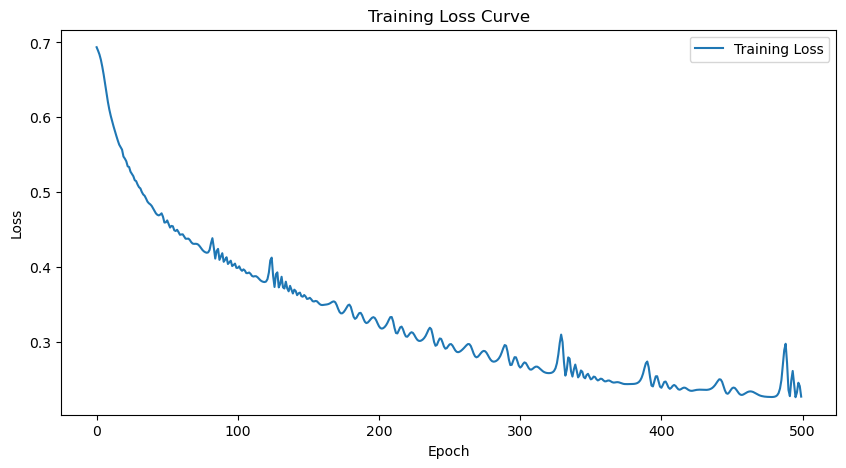

Final Model Accuracy: 77.11%


In [22]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_test.pth'.


In [24]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.85      0.65      0.73       283
non_infringement       0.73      0.89      0.80       298

        accuracy                           0.77       581
       macro avg       0.79      0.77      0.77       581
    weighted avg       0.79      0.77      0.77       581



/tmp/ipykernel_1881491/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 